#### Import libraries & set-up holidays

In [2]:
import pandas as pd
import numpy as np
#import tiingo
import requests
from tqdm import tqdm
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly



## Create holiday calendar
cal = calendar()

holidays = cal.holidays(start='2000-01-01',
                        end='2030-12-30')

holiday_df = pd.DataFrame(data=holidays,
                          columns = ['date']).assign(holiday='USFederalHoliday')

holiday_df.rename(columns={'date':'ds'},inplace=True)
#holiday_df.to_csv('us_holidays_until_2030.csv')

In [3]:
## The full data for the 5 minute chart is 120k rows starting from late 2016, it takes 5 minutes to train the prophet model and a minute to make the forecast

#### Connect to tiingo

In [4]:
# 15min to # 1h 
headers = {
    'Content-Type': 'application/json'
}
requestResponse = requests.get("https://api.tiingo.com/iex/SPY/prices?startDate=2015-01-02&endDate=2022-12-31&resampleFreq=5min&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
#print(requestResponse.json())

In [5]:
## The earliest Tiingo 5 min data starts from 2016-12-01 
ticker = 'SPY'
tiingo_time_interval = '1hour'
## Tiingo time intervals accepted = 5min, 15min, 30min, 1hour, 4hour


# Generate month_start and month end to use for looping over and getting data month by month
month_start_date  = pd.date_range(start='12/1/2016', end='12/1/2022', freq='MS').strftime('%Y-%m-%d')
month_end_date  = pd.date_range(start='12/1/2016', end='12/31/2022', freq='M').strftime('%Y-%m-%d')
print("the size of the monthly data is " + str(month_end_date.size))


# Below loop gets data for each month on a given interval level for a given ticker

total_df = pd.DataFrame()
for x in tqdm(range(month_start_date.size)):
    month_start = month_start_date[x]
    month_end  = month_end_date[x]
    requestResponse = requests.get("https://api.tiingo.com/iex/"+str(ticker)+"/prices?startDate="+str(month_start)+"&endDate="+str(month_end)+"&resampleFreq="+str(tiingo_time_interval)+"&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
    #print(x) 
    #print("https://api.tiingo.com/iex/SPY/prices?startDate="+str(month_start)+"&endDate="+str(month_end)+"&resampleFreq=5min&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b") 
    df_stock = pd.DataFrame(requestResponse.json()) 

    total_df = total_df.append(df_stock)

print('Data download done for the ticker '+str(ticker)+' with a earliest date ' +str(total_df.date.min())+' and latest date '+str(total_df.date.max()))
total_df.to_csv('spy_5_min_all_data.csv')

  0%|          | 0/73 [00:00<?, ?it/s]

the size of the monthly data is 73


100%|██████████| 73/73 [00:34<00:00,  2.14it/s]

Data download done for the ticker SPY with a earliest date 2016-12-12T15:00:00.000Z and latest date 2022-12-05T21:00:00.000Z


In [6]:
df_stock = total_df
df_stock.date = pd.to_datetime(df_stock.date)

## Remove the US public holidays
df_stock = df_stock[~df_stock.date.dt.date.isin(holiday_df.ds)]
df_stock.dtypes

c:\Users\IvanIvanov\Anaconda3\lib\site-packages\pandas\core\algorithms.py:524: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return f(comps, values)


date      datetime64[ns, UTC]
open                  float64
high                  float64
low                   float64
close                 float64
volume                float64
dtype: object

In [7]:
df_stock.rename(columns={"date": "ds", "close": "y"},inplace=True)
df_stock.ds = df_stock.ds.dt.tz_convert(None)
df_stock.ds.dt.day_name().value_counts()

Thursday     2182
Tuesday      2177
Wednesday    2176
Friday       2167
Monday       2156
Name: ds, dtype: int64

In [8]:
print(df_stock.shape)
df_stock.ds.dt.hour.value_counts()
mask = np.logical_and(df_stock.ds.dt.hour >= 13,
                      df_stock.ds.dt.hour <= 20)
df_stock = df_stock[mask]
df_stock = df_stock.sort_values('ds',  ascending=True)
df_stock.reset_index(drop=True,inplace=True)
print(df_stock.shape)

(10858, 6)
(10325, 6)


In [9]:
df_stock

ds     open     high      low        y    volume
0     2016-12-12 15:00:00  226.820  226.960  226.160  226.340   99337.0
1     2016-12-12 16:00:00  226.340  226.495  226.045  226.145  110755.0
2     2016-12-12 17:00:00  226.145  226.145  225.755  225.970   88971.0
3     2016-12-12 18:00:00  225.970  226.190  225.885  225.945   86529.0
4     2016-12-12 19:00:00  225.935  226.250  225.860  225.980  102367.0
...                   ...      ...      ...      ...      ...       ...
10320 2022-12-05 16:00:00  403.375  403.975  400.890  400.970  229907.0
10321 2022-12-05 17:00:00  400.945  401.835  400.240  400.350  174295.0
10322 2022-12-05 18:00:00  400.370  400.950  399.085  399.205  131280.0
10323 2022-12-05 19:00:00  399.180  399.710  398.175  398.930  180346.0
10324 2022-12-05 20:00:00  398.925  399.965  398.620  399.590  438947.0

[10325 rows x 6 columns]

#### Prophet

In [10]:
# Python
m = Prophet(holidays=holiday_df, growth = 'linear')
# m = Prophet(holidays=holiday_df, growth = 'linear')
m.fit(df_stock[['ds','y']])

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [34]:
# Python
future = m.make_future_dataframe(periods=200,freq="1h")
future.tail()

ds
10520 2022-12-14 00:00:00
10521 2022-12-14 01:00:00
10522 2022-12-14 02:00:00
10523 2022-12-14 03:00:00
10524 2022-12-14 04:00:00

In [35]:
mask = np.logical_and(future.ds.dt.hour >= 13,
                      future.ds.dt.hour <= 20)
future = future[mask]
future = future.sort_values('ds',  ascending=True)
future.reset_index(drop=True,inplace=True)
future.shape

(10389, 1)

#### Prediction results

In [41]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(60)

ds        yhat  yhat_lower  yhat_upper
10329 2022-12-06 17:00:00  391.415986  379.930830  402.527427
10330 2022-12-06 18:00:00  391.407978  380.347984  402.628650
10331 2022-12-06 19:00:00  391.398095  379.849505  402.024693
10332 2022-12-06 20:00:00  391.378277  379.712681  402.905304
10333 2022-12-07 13:00:00  391.600040  380.717941  402.560402
10334 2022-12-07 14:00:00  391.348888  380.345419  403.393154
10335 2022-12-07 15:00:00  391.361067  379.860822  402.212172
10336 2022-12-07 16:00:00  391.369928  379.971233  403.171109
10337 2022-12-07 17:00:00  391.343903  380.159490  402.041037
10338 2022-12-07 18:00:00  391.329906  380.832687  402.138329
10339 2022-12-07 19:00:00  391.314173  380.536667  402.751449
10340 2022-12-07 20:00:00  391.288483  380.147173  401.940892
10341 2022-12-08 13:00:00  391.254089  380.903562  402.471184
10342 2022-12-08 14:00:00  390.974450  380.178303  402.441753
10343 2022-12-08 15:00:00  390.957074  379.104863  402.132220
10344 2022-12-08 16:00:00  390.935547  379.965970  402.652081
10345 2022-12-08 17:00:00  390.878566  379.013784  401.980088
10346 2022-12-08 18:00:00  390.833340  379.933019  401.272654
10347 2022-12-08 19:00:00  390.786425  380.332135  402.863991
10348 2022-12-08 20:00:00  390.729942  378.711323  401.505129
10349 2022-12-09 13:00:00  390.579100  379.957864  402.638842
10350 2022-12-09 14:00:00  390.332082  379.219128  401.193420
10351 2022-12-09 15:00:00  390.352301  379.433598  402.283422
10352 2022-12-09 16:00:00  390.373186  379.348531  402.198963
10353 2022-12-09 17:00:00  390.363223  378.885396  402.255387
10354 2022-12-09 18:00:00  390.369352  379.518051  401.589947
10355 2022-12-09 19:00:00  390.377811  379.374360  402.033895
10356 2022-12-09 20:00:00  390.380346  378.698251  401.709923
10357 2022-12-10 13:00:00  391.263761  380.040495  402.062798
10358 2022-12-10 14:00:00  391.045344  379.757336  401.972767
10359 2022-12-10 15:00:00  391.087292  380.123136  402.343470
10360 2022-12-10 16:00:00  391.122721  379.922866  402.475222
10361 2022-12-10 17:00:00  391.119865  379.571804  402.728786
10362 2022-12-10 18:00:00  391.125478  379.943840  402.843900
10363 2022-12-10 19:00:00  391.125682  379.899812  401.777112
10364 2022-12-10 20:00:00  391.112175  379.484031  402.551236
10365 2022-12-11 13:00:00  390.806697  380.332255  401.609660
10366 2022-12-11 14:00:00  390.495562  379.106430  401.786200
10367 2022-12-11 15:00:00  390.446667  379.517072  402.175876
10368 2022-12-11 16:00:00  390.393837  379.487514  402.362520
10369 2022-12-11 17:00:00  390.305986  378.491311  401.180737
10370 2022-12-11 18:00:00  390.230518  378.745485  400.885757
10371 2022-12-11 19:00:00  390.154159  379.319992  400.620790
10372 2022-12-11 20:00:00  390.069171  378.680962  400.973729
10373 2022-12-12 13:00:00  389.581408  378.785601  400.700237
10374 2022-12-12 14:00:00  389.317186  378.353606  401.092205
10375 2022-12-12 15:00:00  389.319453  378.792977  399.869017
10376 2022-12-12 16:00:00  389.321488  377.970347  400.008233
10377 2022-12-12 17:00:00  389.291638  377.689511  400.160846
10378 2022-12-12 18:00:00  389.276730  378.104018  401.292012
10379 2022-12-12 19:00:00  389.262907  378.469401  400.745960
10380 2022-12-12 20:00:00  389.241849  378.337587  399.909351
10381 2022-12-13 13:00:00  389.598959  377.845276  400.148912
10382 2022-12-13 14:00:00  389.354260  377.244607  401.610308
10383 2022-12-13 15:00:00  389.372346  377.855754  400.511992
10384 2022-12-13 16:00:00  389.386654  377.659809  400.212110
10385 2022-12-13 17:00:00  389.365723  378.972537  400.795912
10386 2022-12-13 18:00:00  389.356598  378.166682  401.018641
10387 2022-12-13 19:00:00  389.345665  377.659142  399.856255
10388 2022-12-13 20:00:00  389.324866  378.860533  401.436198

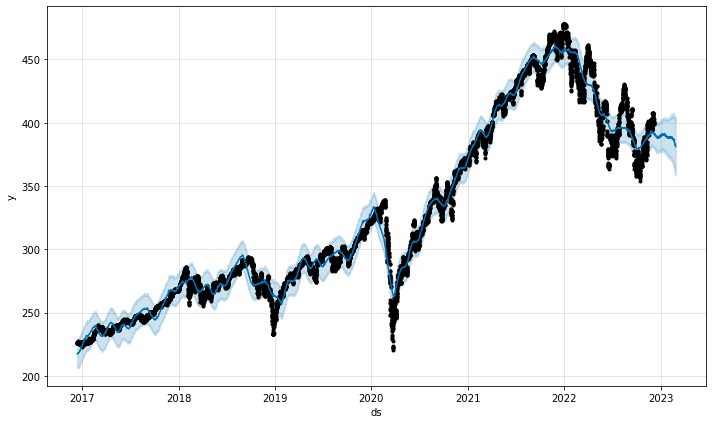

In [27]:
# Python
fig1 = m.plot(forecast)

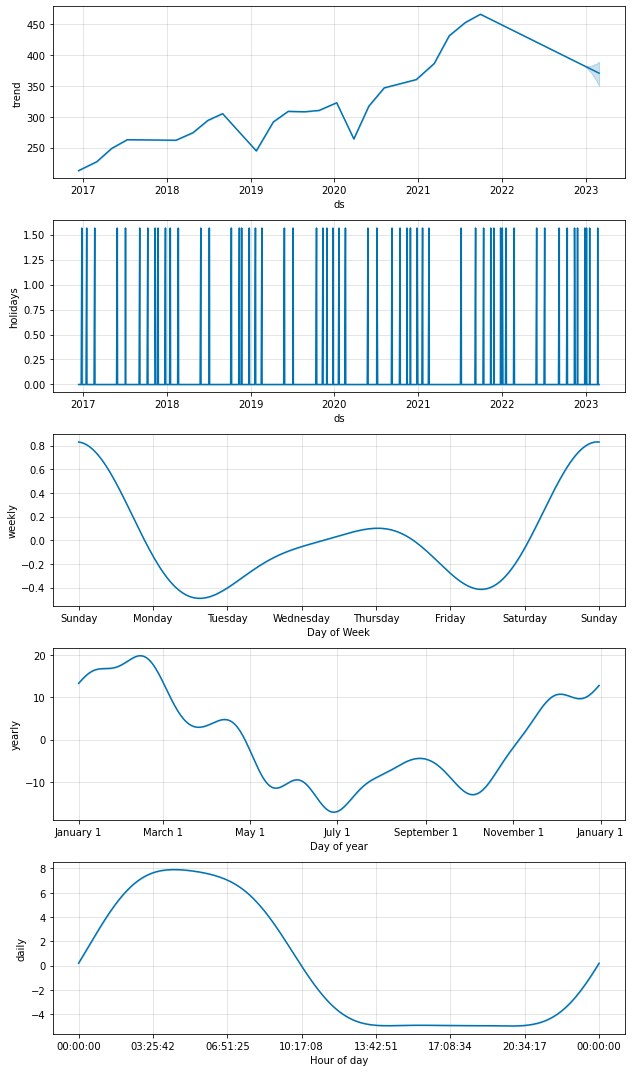

In [28]:
# Python
fig2 = m.plot_components(forecast)

In [29]:
# Python
plot_plotly(m, forecast)

In [30]:
# Python
plot_components_plotly(m, forecast)

#### Appendix

In [31]:
#### Test the earleist data available for give ticker

# ticker = 'SPY'

# x = 77


# # Generate month_start and month end to use for looping over and getting data month by month
# month_start_date  = pd.date_range(start='12/1/2010', end='12/1/2022', freq='MS').strftime('%Y-%m-%d')
# month_end_date  = pd.date_range(start='12/1/2010', end='12/31/2022', freq='M').strftime('%Y-%m-%d')
# print("the size of the monthly data is " + str(month_end_date.size))


# month_start = month_start_date[x]
# month_end = month_start_date[x]

# print(month_start_date[x])


# requestResponse = requests.get("https://api.tiingo.com/iex/"+str(ticker)+"/prices?startDate="+str(month_start)+"&endDate="+str(month_end)+"&resampleFreq=15min&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
# print(x) 
# #print("https://api.tiingo.com/iex/SPY/prices?startDate="+str(month_start)+"&endDate="+str(month_end)+"&resampleFreq=5min&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b") 
# df_stock = pd.DataFrame(requestResponse.json()) 
# df_stock


In [20]:
# import xgboost as xgb 
# clf_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
#                             tree_method = 'gpu_hist',
#                             gamma = 0.5,
#                            max_depth = 25,
#                             seed=42,
#                             n_estimators=30)

In [21]:
# clf_xgb.fit(X_train,
#             y_train,
#            verbose=True,
#             early_stopping_rounds=20,
#             eval_metric='rmse',   #aucpr,auc, map
#             eval_set=[(X_test,y_test)])